# ACO Hyperparameter Tuning for Graph Coloring Problem

This notebook performs hyperparameter tuning for Ant Colony Optimization (ACO) algorithm applied to the Graph Coloring Problem using Optuna.

## 1. Environment Setup

In [1]:
import sys
import os

# Check if running in Google Colab environment
IS_COLAB = 'google.colab' in sys.modules

print(f"Running in Google Colab: {IS_COLAB}")

if IS_COLAB:
    print("Colab environment detected. Will mount Google Drive.")
    # Mount Google Drive if running in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully at /content/drive")
else:
    print("Local environment detected. Using local paths.")

Running in Google Colab: False
Local environment detected. Using local paths.


In [2]:
# Configure paths for data, studies, results, and figures based on the execution environment.
from pathlib import Path

# Configure base paths based on environment
if IS_COLAB:
    # Update this path to match your Google Drive structure
    BASE_PATH = Path('/content/drive/MyDrive/meta_graph_coloring_antcol/assignemnt3')
    CODE_PATH = BASE_PATH / 'code'
    # Add code path to system path for imports
    sys.path.insert(0, str(CODE_PATH))
else:
    # Local environment paths
    BASE_PATH = Path('/Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3')
    CODE_PATH = BASE_PATH / 'code'

# Define data root path (contains tiny_dataset and main_dataset)
DATA_ROOT = BASE_PATH / 'data'

# Verify paths exist
if not BASE_PATH.exists():
    raise FileNotFoundError(f"Base path does not exist: {BASE_PATH}")
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Data root does not exist: {DATA_ROOT}")

print(f"Base Path: {BASE_PATH}")
print(f"Code Path: {CODE_PATH}")
print(f"Data Root: {DATA_ROOT}")
print(f"\nPath verification: OK")

Base Path: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3
Code Path: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/code
Data Root: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data

Path verification: OK


In [3]:
# Install required packages if running in Colab
if IS_COLAB:
    print("Installing required packages...")
    !pip install -q networkx==3.2.1 matplotlib==3.8.2 pandas==2.1.4 numpy==1.26.2 optuna==3.5.0 scikit-learn==1.4.0 scipy==1.11.4
    print("Packages installed successfully!")

In [4]:
# Import Required Libraries

import multiprocessing
from datetime import datetime
from IPython.display import Image, display, Markdown

# Import project modules
from dataloader import GraphDataLoader
from optuna_tuner import OptunaACOTuner
from aco_gpc import ACOGraphColoring
from objective_function import aco_objective_function
from results_utils import visualize_testing_results, export_results, print_summary_statistics, print_file_locations

print("All libraries imported successfully!")

/Users/mahdy/projects/meta_graph_coloring_antcol/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!


## 2. Study Configuration

Define dataset selection, study name, and hyperparameter search space.

In [5]:
# Dataset selection: 'tiny_dataset' for quick testing, 'main_dataset' for full experiments
DATASET_NAME = 'tiny_dataset'  # Change to 'main_dataset' for full tuning

# Study continuation mode
# Option 1: Continue existing study - set CONTINUE_STUDY to the study name
# Example: CONTINUE_STUDY = 'aco_study_tiny_dataset_20251129_172927'
# Option 2: Start new study - set CONTINUE_STUDY = None
CONTINUE_STUDY = None  # Set to study name to continue, or None for new study

# Study name (used for new studies or when CONTINUE_STUDY is None)
if CONTINUE_STUDY:
    STUDY_NAME = CONTINUE_STUDY
    print(f"Continuing existing study: {STUDY_NAME}")
else:
    STUDY_NAME = f'aco_study_{DATASET_NAME}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    print(f"Creating new study: {STUDY_NAME}")

# Number of Optuna trials for hyperparameter tuning
N_TRIALS = 5

# ACO verbose setting 
ACO_VERBOSE = False   # Set to True to see detailed ACO progress

# Hyperparameter search space configuration (parameters to optimize)
PARAM_CONFIG = {
    'iterations': {
        'type': 'int',
        'low': 50,
        'high': 200,
    },
    'alpha': {
        'type': 'float',
        'low': 0.5,
        'high': 3.0,
    },
    'beta': {
        'type': 'float',
        'low': 1.0,
        'high': 5.0,
    },
    'rho': {
        'type': 'float',
        'low': 0.01,
        'high': 0.5,
    },
    'ant_count': {
        'type': 'int',
        'low': 10,
        'high': 50,
    },
    'Q': {
        'type': 'float',
        'low': 0.1,
        'high': 10.0,
    }
}

print(f"Configuration:")
print(f"  Dataset: {DATASET_NAME}")
print(f"  Study Name: {STUDY_NAME}")
print(f"  Optuna Trials: {N_TRIALS}")
print(f"\nHyperparameters to Optimize:")
for param_name, param_spec in PARAM_CONFIG.items():
    print(f"  {param_name}: [{param_spec['low']}, {param_spec['high']}] ({param_spec['type']})")

Creating new study: aco_study_tiny_dataset_20251129_192552
Configuration:
  Dataset: tiny_dataset
  Study Name: aco_study_tiny_dataset_20251129_192552
  Optuna Trials: 5

Hyperparameters to Optimize:
  iterations: [50, 200] (int)
  alpha: [0.5, 3.0] (float)
  beta: [1.0, 5.0] (float)
  rho: [0.01, 0.5] (float)
  ant_count: [10, 50] (int)
  Q: [0.1, 10.0] (float)


In [6]:
# Initialize the Optuna tuner
tuner = OptunaACOTuner(
    study_name=STUDY_NAME,
    data_root=str(DATA_ROOT),
    direction='minimize'  # We want to minimize the number of colors used
)

print(f"Tuner initialized with study: {STUDY_NAME}")
print(f"Data root: {DATA_ROOT}")

# Load tuning dataset once (before optimization)
print("\nLoading tuning dataset...")
data_loader = GraphDataLoader(str(DATA_ROOT), DATASET_NAME)
tuning_graphs = data_loader.load_tuning_dataset()
print(f"Loaded {len(tuning_graphs)} graphs for tuning\n")

# Wrapper function to pass tuning graphs to objective function
def objective_wrapper(trial, params, **kwargs):
    return aco_objective_function(
        trial=trial,
        params=params,
        tuning_graphs=tuning_graphs,
        aco_class=ACOGraphColoring,
        verbose=ACO_VERBOSE
    )

print("Objective function wrapper ready!")

Tuner initialized with study: aco_study_tiny_dataset_20251129_192552
Data root: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data

Loading tuning dataset...

Loading Tuning Dataset: tiny_dataset
  gc_20_9:
    Nodes: 22, Edges: 165
    Density: 0.7143, Connected: False
  gc_4_1:
    Nodes: 5, Edges: 4
    Density: 0.4000, Connected: True
  gc_50_9:
    Nodes: 52, Edges: 1104
    Density: 0.8326, Connected: False

Loaded 3 graphs for tuning

Objective function wrapper ready!


## 3. Run Optimization

In [7]:
# Run the hyperparameter optimization
print(f"\nStarting hyperparameter optimization with {N_TRIALS} trials...")
print("=" * 70)

best_params = tuner.optimize(
    objective_func=objective_wrapper,
    param_config=PARAM_CONFIG,
    aco_class=ACOGraphColoring,
    n_trials=N_TRIALS
)

print("\n" + "=" * 70)
print("Optimization completed!")
print("\nBest Parameters Found:")
for param_name, param_value in best_params.items():
    print(f"  {param_name}: {param_value}")

[I 2025-11-29 19:25:52,041] A new study created in Journal with name: aco_study_tiny_dataset_20251129_192552



Starting hyperparameter optimization with 5 trials...
✓ Created new study 'aco_study_tiny_dataset_20251129_192552'
  Storage: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data/studies/aco_study_tiny_dataset_20251129_192552/aco_study_tiny_dataset_20251129_192552.log
Completed trials: 0/5
Remaining trials: 5

Starting optimization with 5 trials...


  0%|          | 0/5 [00:00<?, ?it/s]


Trial 0: Testing hyperparameters
----------------------------------------------------------------------

Graph 1/3: gc_20_9 (nodes=22, edges=165)
  ✓ Result: 6 colors used, 16 conflicts
  ✓ Available colors: 21 (started with 11)
  ✓ Time: 3.28s

Graph 2/3: gc_4_1 (nodes=5, edges=4)
  ✓ Result: 3 colors used, 0 conflicts
  ✓ Available colors: 10 (started with 10)
  ✓ Time: 0.01s

Graph 3/3: gc_50_9 (nodes=52, edges=1104)
  ✓ Result: 6 colors used, 16 conflicts
  ✓ Available colors: 21 (started with 11)
  ✓ Time: 3.28s

Graph 2/3: gc_4_1 (nodes=5, edges=4)
  ✓ Result: 3 colors used, 0 conflicts
  ✓ Available colors: 10 (started with 10)
  ✓ Time: 0.01s

Graph 3/3: gc_50_9 (nodes=52, edges=1104)


  0%|          | 0/5 [00:19<?, ?it/s]

  ✓ Result: 19 colors used, 27 conflicts
  ✓ Available colors: 35 (started with 26)
  ✓ Time: 16.36s

----------------------------------------------------------------------
Trial 0 Summary:
  Total colors across all graphs: 28
  Average colors per graph: 9.33

[I 2025-11-29 19:26:11,701] Trial 0 finished with value: 28.0 and parameters: {'iterations': 119, 'alpha': 2.0968314730591016, 'beta': 1.4013535443518572, 'rho': 0.1523161794283518, 'ant_count': 48, 'Q': 6.688753893198804}. Best is trial 0 with value: 28.0.


Best trial: 0. Best value: 28:  20%|██        | 1/5 [00:20<01:20, 20.09s/it]

    Saved trial visualizations: 3 metric plots, 3 graph plots

Trial 1: Testing hyperparameters
----------------------------------------------------------------------

Graph 1/3: gc_20_9 (nodes=22, edges=165)
  ✓ Result: 8 colors used, 8 conflicts
  ✓ Available colors: 24 (started with 11)
  ✓ Time: 3.80s

Graph 2/3: gc_4_1 (nodes=5, edges=4)
  ✓ Result: 3 colors used, 0 conflicts
  ✓ Available colors: 10 (started with 10)
  ✓ Time: 0.01s

Graph 3/3: gc_50_9 (nodes=52, edges=1104)
  ✓ Result: 8 colors used, 8 conflicts
  ✓ Available colors: 24 (started with 11)
  ✓ Time: 3.80s

Graph 2/3: gc_4_1 (nodes=5, edges=4)
  ✓ Result: 3 colors used, 0 conflicts
  ✓ Available colors: 10 (started with 10)
  ✓ Time: 0.01s

Graph 3/3: gc_50_9 (nodes=52, edges=1104)


Best trial: 0. Best value: 28:  20%|██        | 1/5 [00:42<01:20, 20.09s/it]

  ✓ Result: 21 colors used, 18 conflicts
  ✓ Available colors: 36 (started with 26)
  ✓ Time: 18.79s

----------------------------------------------------------------------
Trial 1 Summary:
  Total colors across all graphs: 32
  Average colors per graph: 10.67

[I 2025-11-29 19:26:34,747] Trial 1 finished with value: 32.0 and parameters: {'iterations': 140, 'alpha': 2.466399618525963, 'beta': 1.3210506427860897, 'rho': 0.21157618098573225, 'ant_count': 46, 'Q': 7.920406058368194}. Best is trial 0 with value: 28.0.


Best trial: 0. Best value: 28:  40%|████      | 2/5 [00:42<01:05, 21.74s/it]

    Saved trial visualizations: 3 metric plots, 3 graph plots

Trial 2: Testing hyperparameters
----------------------------------------------------------------------

Graph 1/3: gc_20_9 (nodes=22, edges=165)
  ✓ Result: 11 colors used, 0 conflicts
  ✓ Available colors: 11 (started with 11)
  ✓ Time: 0.07s

Graph 2/3: gc_4_1 (nodes=5, edges=4)
  ✓ Result: 3 colors used, 0 conflicts
  ✓ Available colors: 10 (started with 10)
  ✓ Time: 0.00s

Graph 3/3: gc_50_9 (nodes=52, edges=1104)


Best trial: 0. Best value: 28:  40%|████      | 2/5 [00:53<01:05, 21.74s/it]

  ✓ Result: 21 colors used, 8 conflicts
  ✓ Available colors: 31 (started with 26)
  ✓ Time: 10.05s

----------------------------------------------------------------------
Trial 2 Summary:
  Total colors across all graphs: 35
  Average colors per graph: 11.67

[I 2025-11-29 19:26:45,169] Trial 2 finished with value: 35.0 and parameters: {'iterations': 100, 'alpha': 1.121493748090511, 'beta': 4.297846377988305, 'rho': 0.46580541360799194, 'ant_count': 37, 'Q': 3.1701897676341955}. Best is trial 0 with value: 28.0.


Best trial: 0. Best value: 28:  60%|██████    | 3/5 [00:53<00:33, 16.57s/it]

    Saved trial visualizations: 3 metric plots, 3 graph plots

Trial 3: Testing hyperparameters
----------------------------------------------------------------------

Graph 1/3: gc_20_9 (nodes=22, edges=165)
  ✓ Result: 8 colors used, 5 conflicts
  ✓ Available colors: 24 (started with 11)
  ✓ Time: 2.41s

Graph 2/3: gc_4_1 (nodes=5, edges=4)
  ✓ Result: 3 colors used, 0 conflicts
  ✓ Available colors: 10 (started with 10)
  ✓ Time: 0.00s

Graph 3/3: gc_50_9 (nodes=52, edges=1104)
  ✓ Result: 8 colors used, 5 conflicts
  ✓ Available colors: 24 (started with 11)
  ✓ Time: 2.41s

Graph 2/3: gc_4_1 (nodes=5, edges=4)
  ✓ Result: 3 colors used, 0 conflicts
  ✓ Available colors: 10 (started with 10)
  ✓ Time: 0.00s

Graph 3/3: gc_50_9 (nodes=52, edges=1104)


Best trial: 0. Best value: 28:  60%|██████    | 3/5 [01:08<00:33, 16.57s/it]

  ✓ Result: 20 colors used, 14 conflicts
  ✓ Available colors: 36 (started with 26)
  ✓ Time: 12.21s

----------------------------------------------------------------------
Trial 3 Summary:
  Total colors across all graphs: 31
  Average colors per graph: 10.33

[I 2025-11-29 19:27:00,079] Trial 3 finished with value: 31.0 and parameters: {'iterations': 153, 'alpha': 1.5482430804849958, 'beta': 3.528486015669927, 'rho': 0.36407063770875336, 'ant_count': 28, 'Q': 4.5866260673366295}. Best is trial 0 with value: 28.0.


Best trial: 0. Best value: 28:  80%|████████  | 4/5 [01:08<00:15, 15.93s/it]

    Saved trial visualizations: 3 metric plots, 3 graph plots

Trial 4: Testing hyperparameters
----------------------------------------------------------------------

Graph 1/3: gc_20_9 (nodes=22, edges=165)
  ✓ Result: 10 colors used, 1 conflicts
  ✓ Available colors: 24 (started with 11)
  ✓ Time: 3.96s

Graph 2/3: gc_4_1 (nodes=5, edges=4)
  ✓ Result: 3 colors used, 0 conflicts
  ✓ Available colors: 10 (started with 10)
  ✓ Time: 0.01s

Graph 3/3: gc_50_9 (nodes=52, edges=1104)
  ✓ Result: 10 colors used, 1 conflicts
  ✓ Available colors: 24 (started with 11)
  ✓ Time: 3.96s

Graph 2/3: gc_4_1 (nodes=5, edges=4)
  ✓ Result: 3 colors used, 0 conflicts
  ✓ Available colors: 10 (started with 10)
  ✓ Time: 0.01s

Graph 3/3: gc_50_9 (nodes=52, edges=1104)


Best trial: 0. Best value: 28:  80%|████████  | 4/5 [01:32<00:15, 15.93s/it]

  ✓ Result: 26 colors used, 0 conflicts
  ✓ Available colors: 38 (started with 26)
  ✓ Time: 20.18s

----------------------------------------------------------------------
Trial 4 Summary:
  Total colors across all graphs: 39
  Average colors per graph: 13.00

[I 2025-11-29 19:27:24,539] Trial 4 finished with value: 39.0 and parameters: {'iterations': 142, 'alpha': 1.2972116302897438, 'beta': 4.903807026552746, 'rho': 0.058697148559285074, 'ant_count': 49, 'Q': 9.316967766133736}. Best is trial 0 with value: 28.0.


Best trial: 0. Best value: 28: 100%|██████████| 5/5 [01:32<00:00, 18.56s/it]

    Saved trial visualizations: 3 metric plots, 3 graph plots

Optimization complete!
Best value: 28.0
Best parameters: {'iterations': 119, 'alpha': 2.0968314730591016, 'beta': 1.4013535443518572, 'rho': 0.1523161794283518, 'ant_count': 48, 'Q': 6.688753893198804}
Study summary saved to: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data/studies/aco_study_tiny_dataset_20251129_192552/aco_study_tiny_dataset_20251129_192552_summary.json

Generating visualization plots...


Optimization history saved to: history.png
Parameter importances saved to: importances.png
Slice plot saved to: slice.png
Timeline plot saved to: timeline.png
All plots generated successfully.


Optimization completed!

Best Parameters Found:
  iterations: 119
  alpha: 2.0968314730591016
  beta: 1.4013535443518572
  rho: 0.1523161794283518
  ant_count: 48
  Q: 6.688753893198804
Slice plot saved to: slice.png
Timeline plot saved to: timeline.png
All plots generated successfully.


Optimization completed!

Best Parameters Found:
  iterations: 119
  alpha: 2.0968314730591016
  beta: 1.4013535443518572
  rho: 0.1523161794283518
  ant_count: 48
  Q: 6.688753893198804


In [8]:
# Generate all optimization plots
print("\nGenerating optimization visualization plots...")
print("=" * 70)
tuner.generate_plots(recreate=True)
print("=" * 70)


Generating optimization visualization plots...

Generating visualization plots...
Optimization history saved to: history.png
Parameter importances saved to: importances.png
Parameter importances saved to: importances.png
Slice plot saved to: slice.png
Timeline plot saved to: timeline.png
All plots generated successfully.

Slice plot saved to: slice.png
Timeline plot saved to: timeline.png
All plots generated successfully.



### Best Trial Results

Best Trial: 0
Best Objective Value: 28.0


#### Best Trial Metrics

**Color Count per Graph**

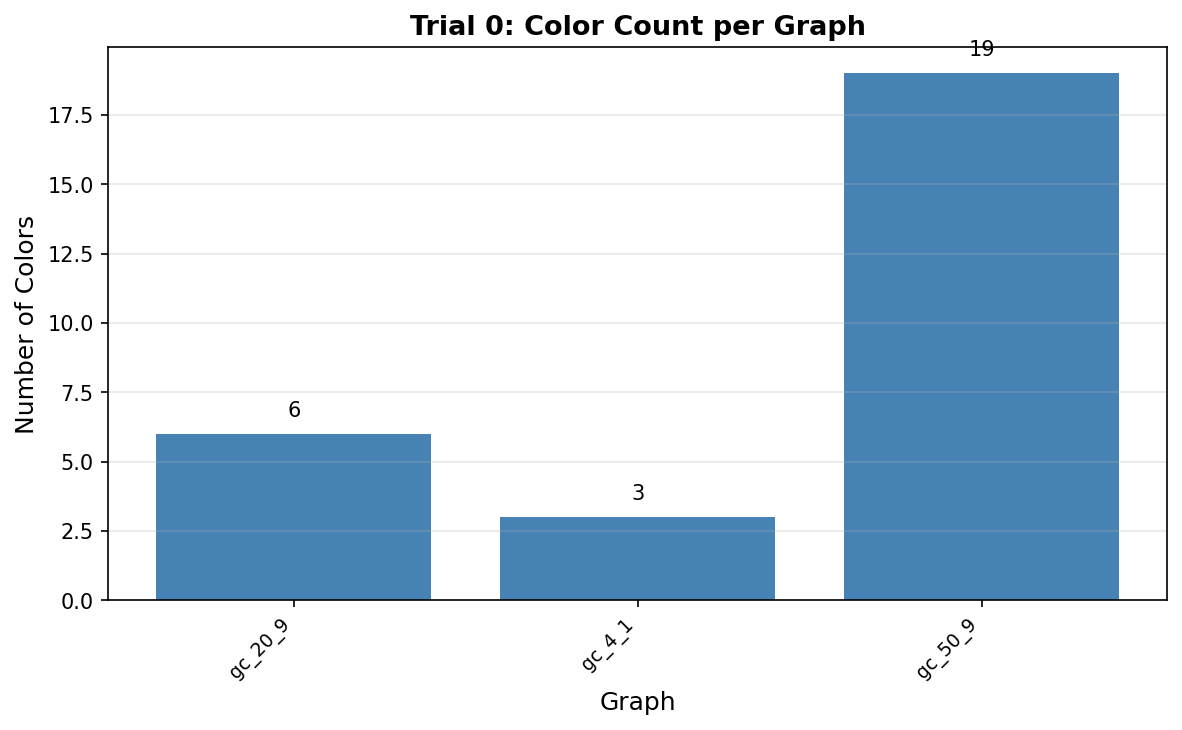

**Execution Time per Graph**

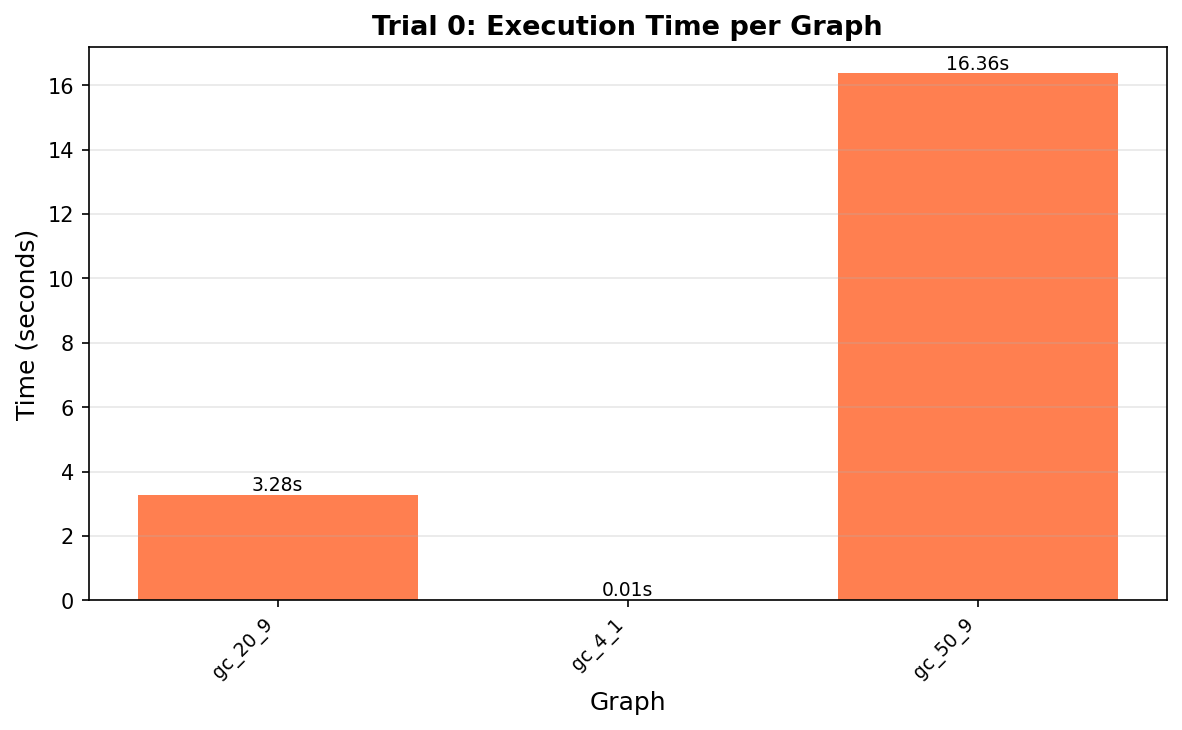

**Conflicts per Graph**

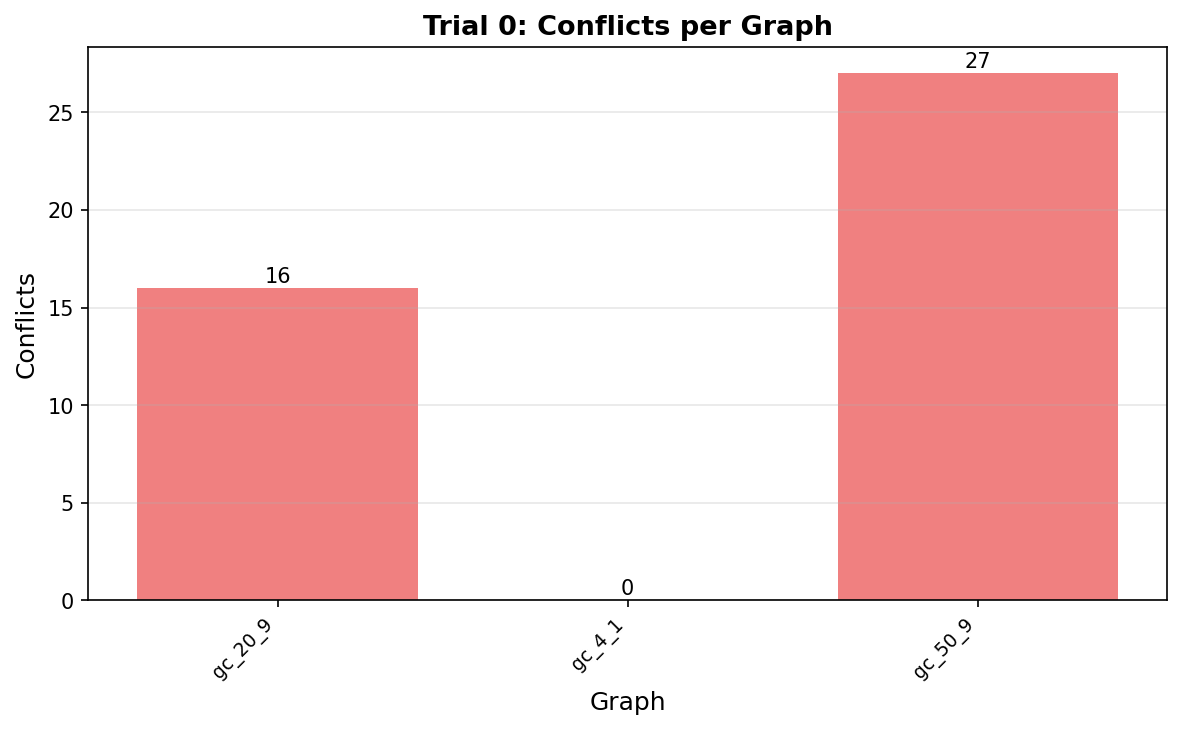

#### Best Trial: Colored Graph Solutions

**gc_20_9**

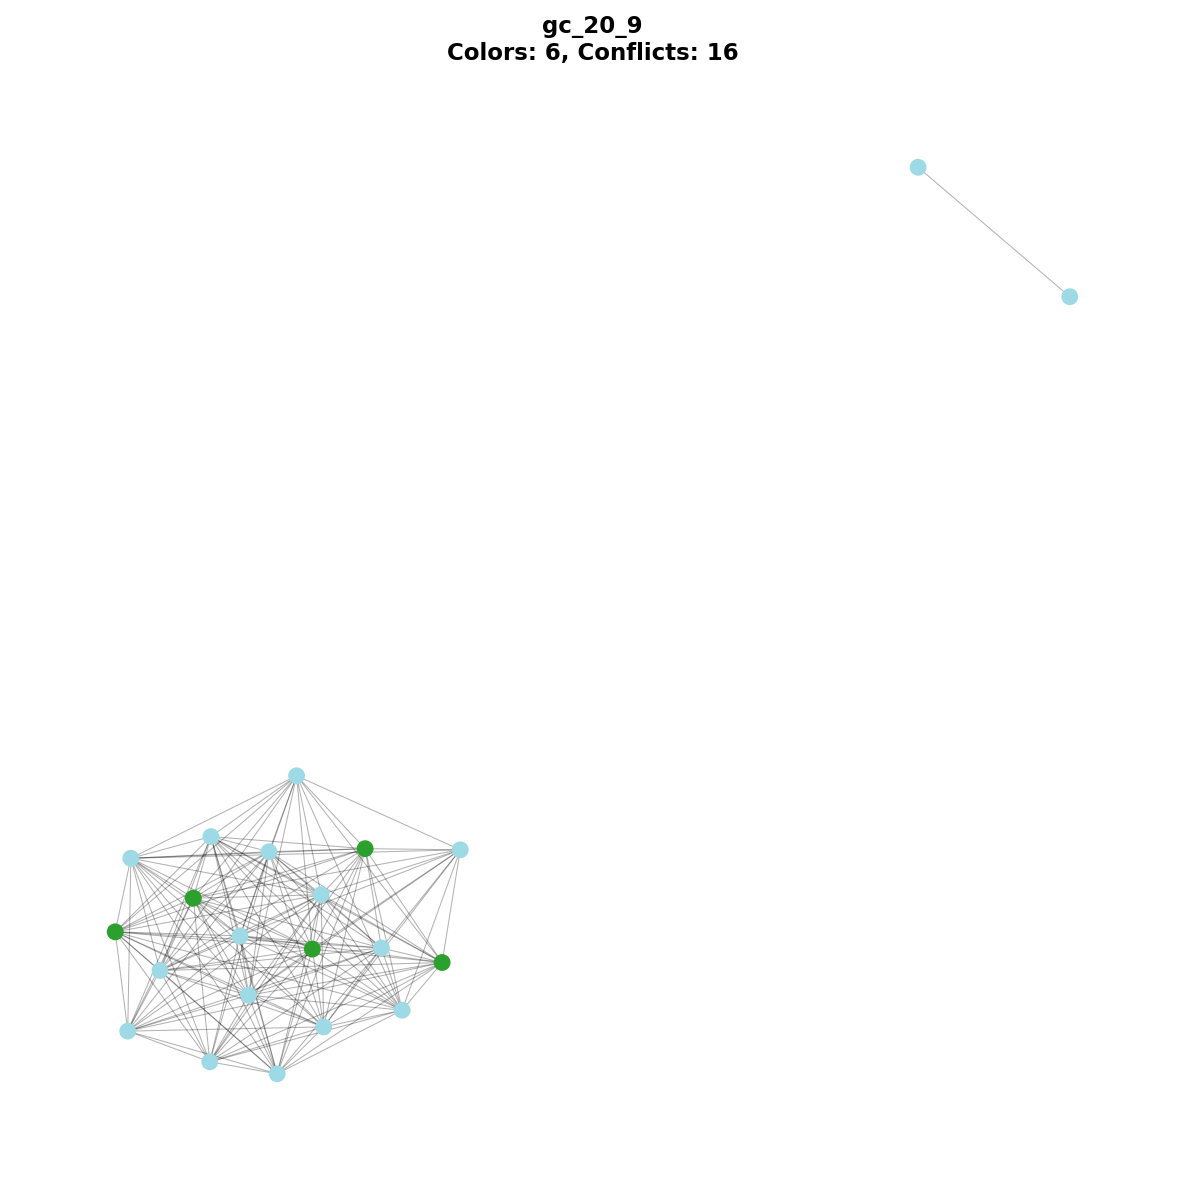

**gc_4_1**

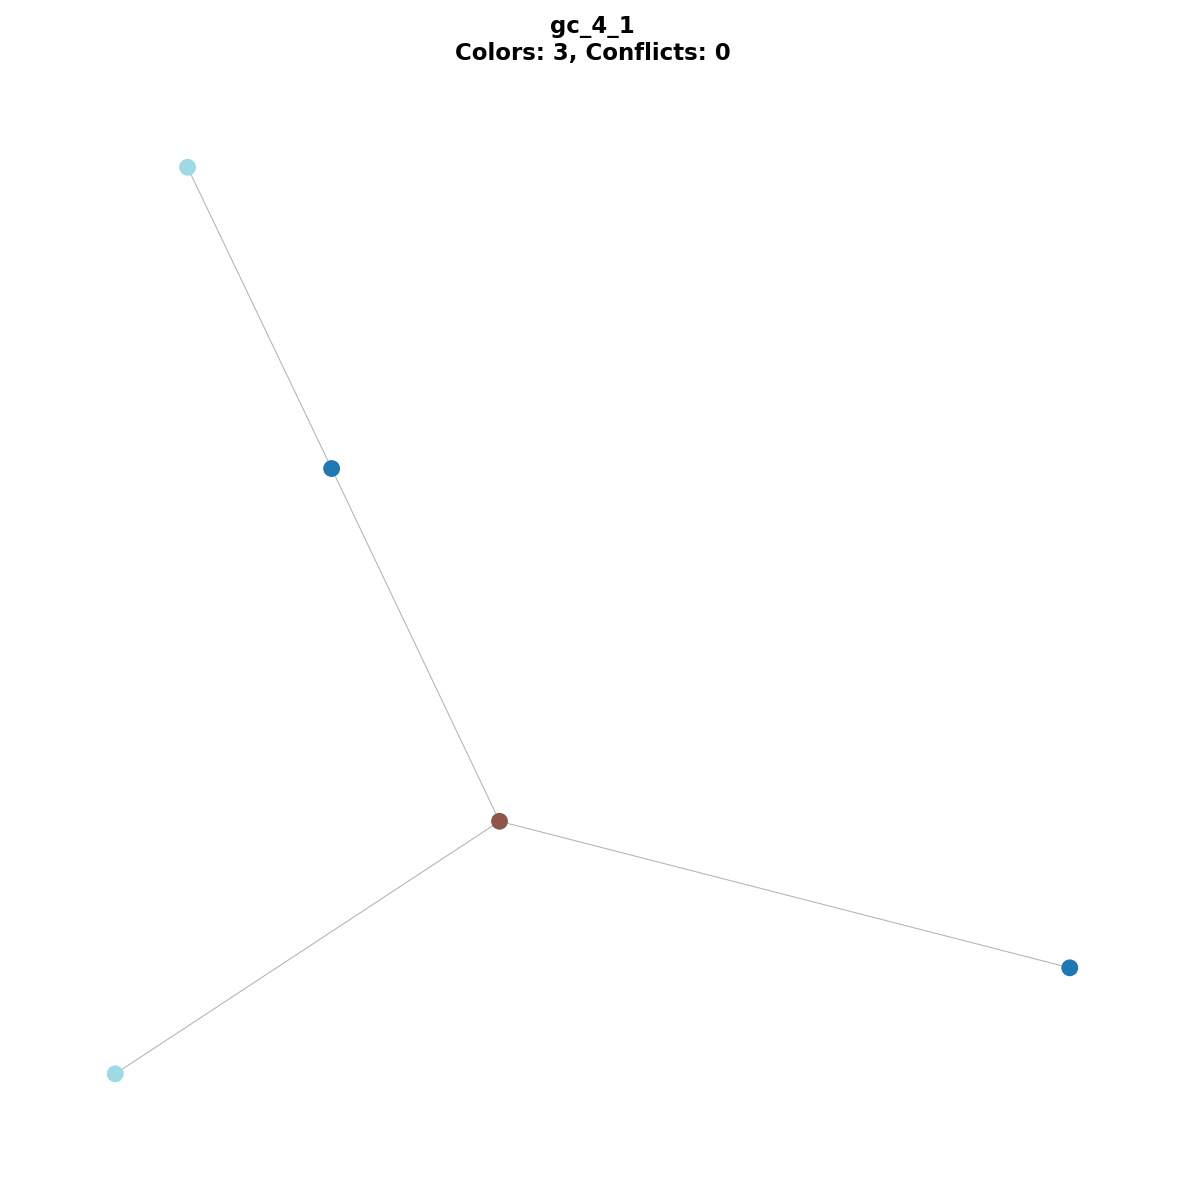

**gc_50_9**

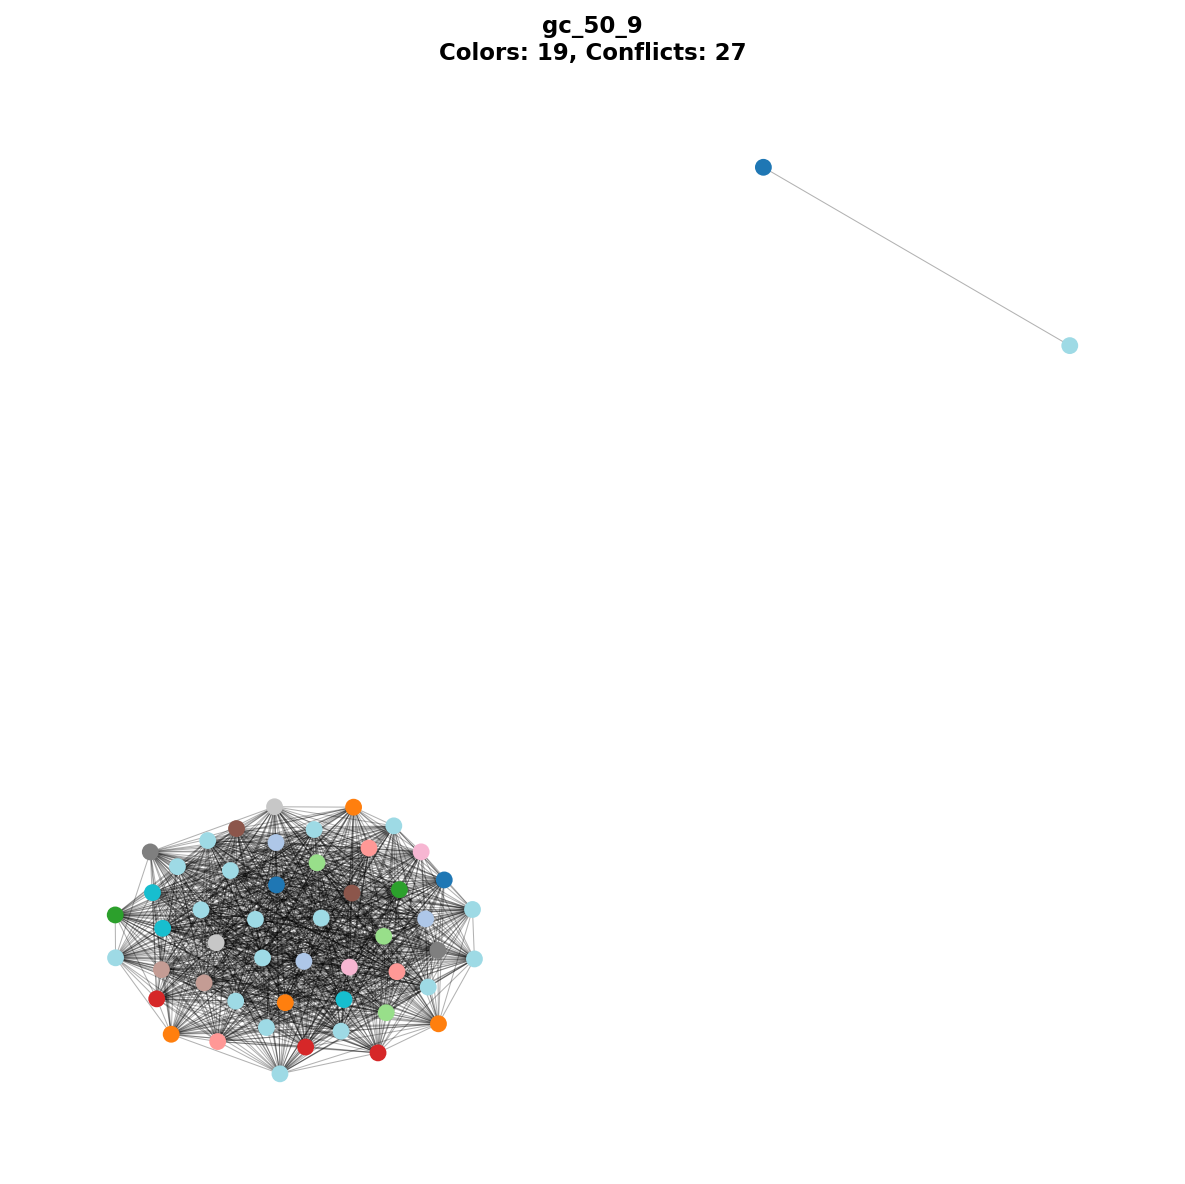

In [9]:
# Display best trial graphs and metrics
from pathlib import Path

# Get best trial number
best_trial_number = tuner.study.best_trial.number
best_trial_dir = Path(DATA_ROOT) / 'studies' / STUDY_NAME / 'results' / f'trial_{best_trial_number:04d}'

print(f"Best Trial: {best_trial_number}")
print(f"Best Objective Value: {tuner.study.best_value}")
print("=" * 70)

# Display metrics for best trial
display(Markdown(f"#### Best Trial Metrics"))

metric_files = [
    ('color_count.png', 'Color Count per Graph'),
    ('execution_time.png', 'Execution Time per Graph'),
    ('conflicts.png', 'Conflicts per Graph')
]

for filename, title in metric_files:
    metric_path = best_trial_dir / filename
    if metric_path.exists():
        display(Markdown(f"**{title}**"))
        display(Image(filename=str(metric_path)))

# Display colored graphs for best trial
display(Markdown(f"#### Best Trial: Colored Graph Solutions"))

# Find all graph files in best trial directory
graph_files = sorted(best_trial_dir.glob('graph_*.png'))
for graph_file in graph_files:
    graph_name = graph_file.stem.replace('graph_', '')
    display(Markdown(f"**{graph_name}**"))
    display(Image(filename=str(graph_file)))

### Display Study Visualizations

Study Visualization Figures:


### Optimization History

*Shows objective value progression across trials*

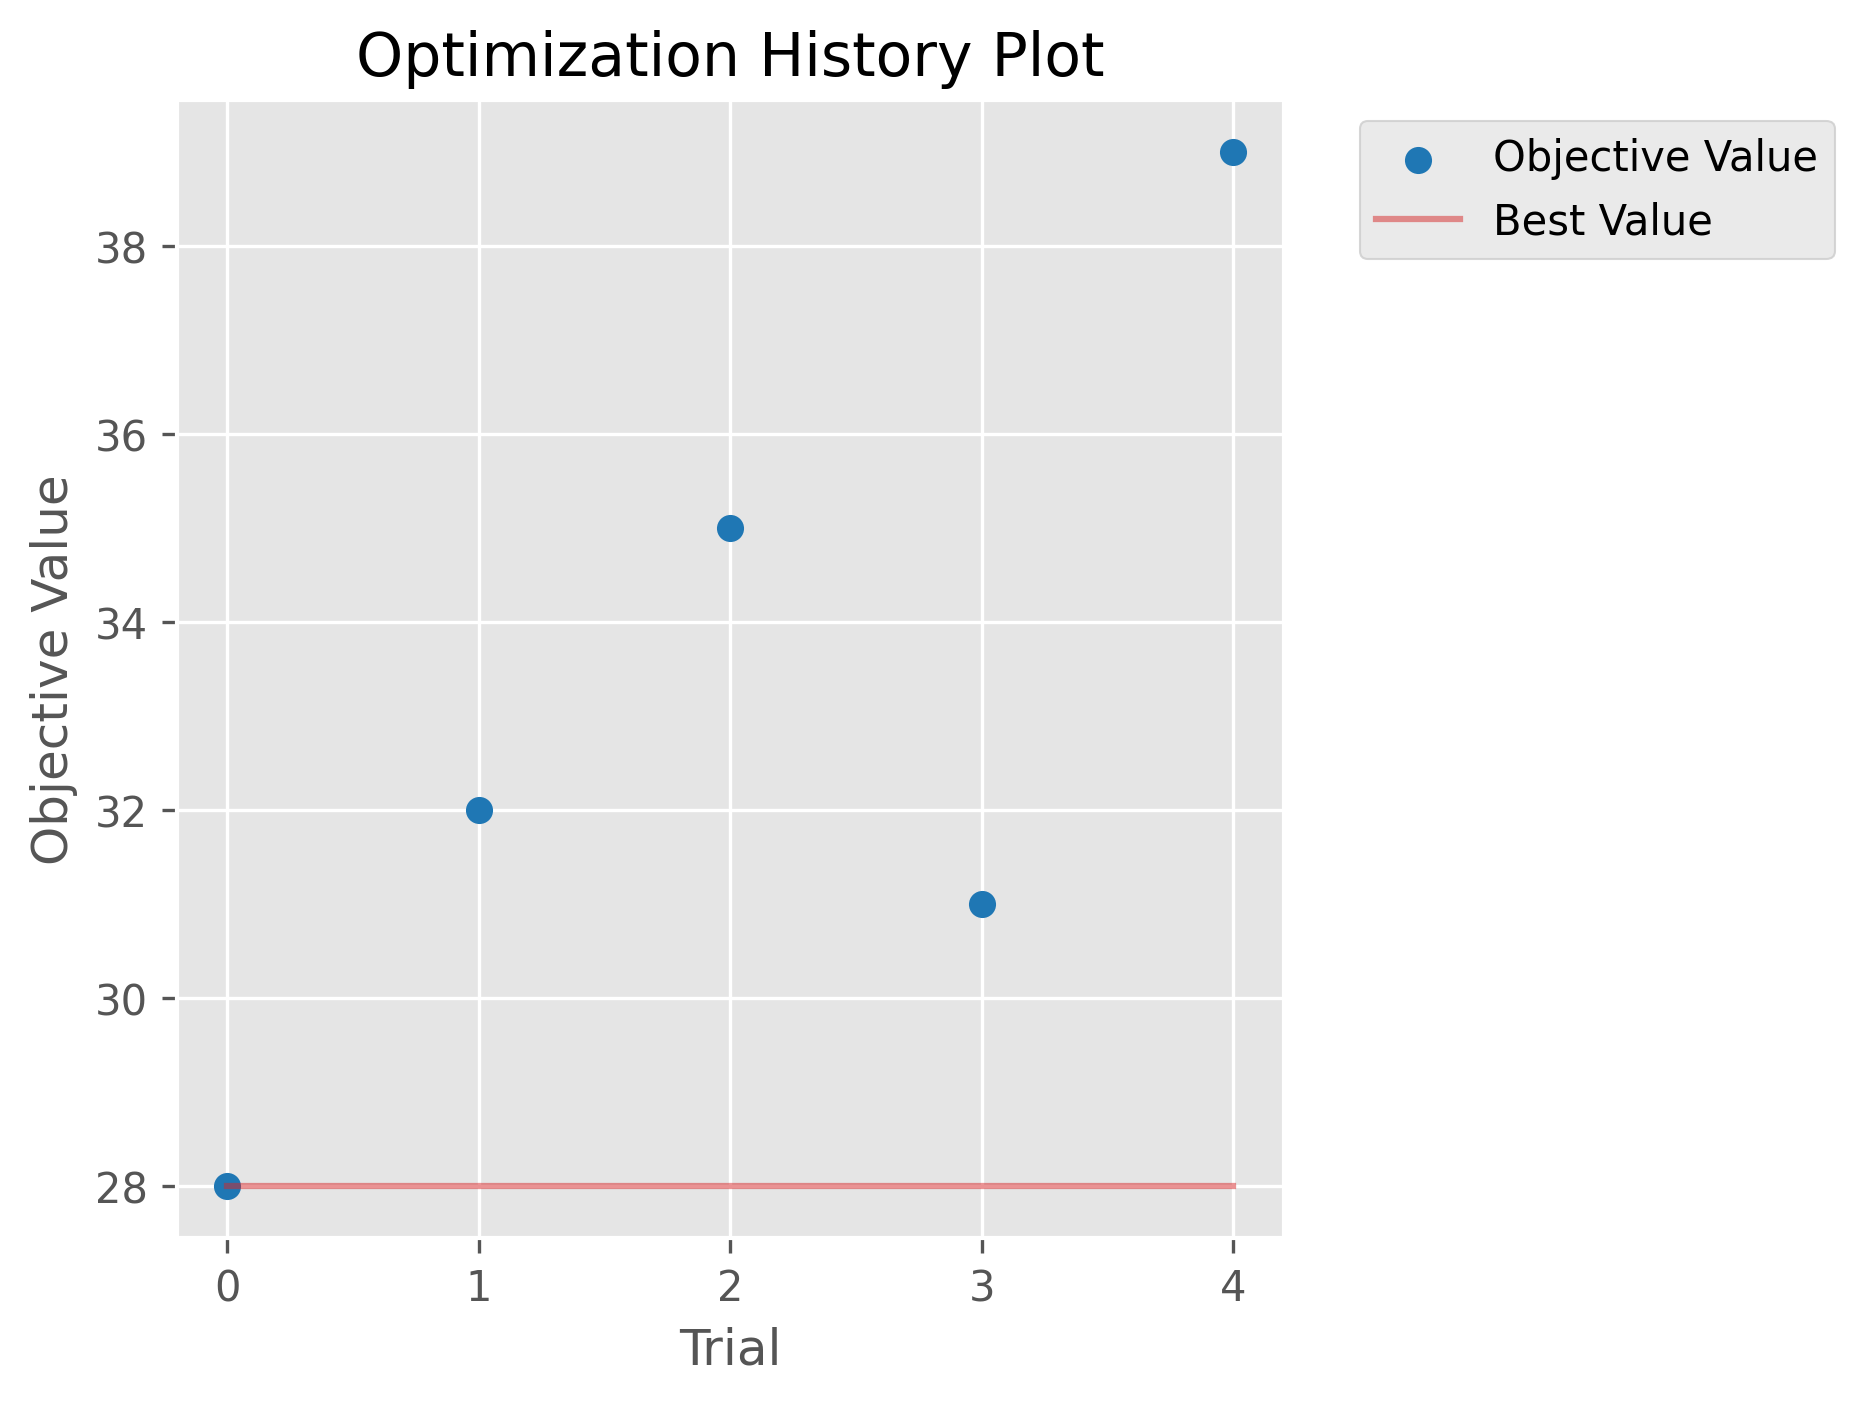

✓ history.png


### Parameter Importances

*Shows which hyperparameters impact results most*

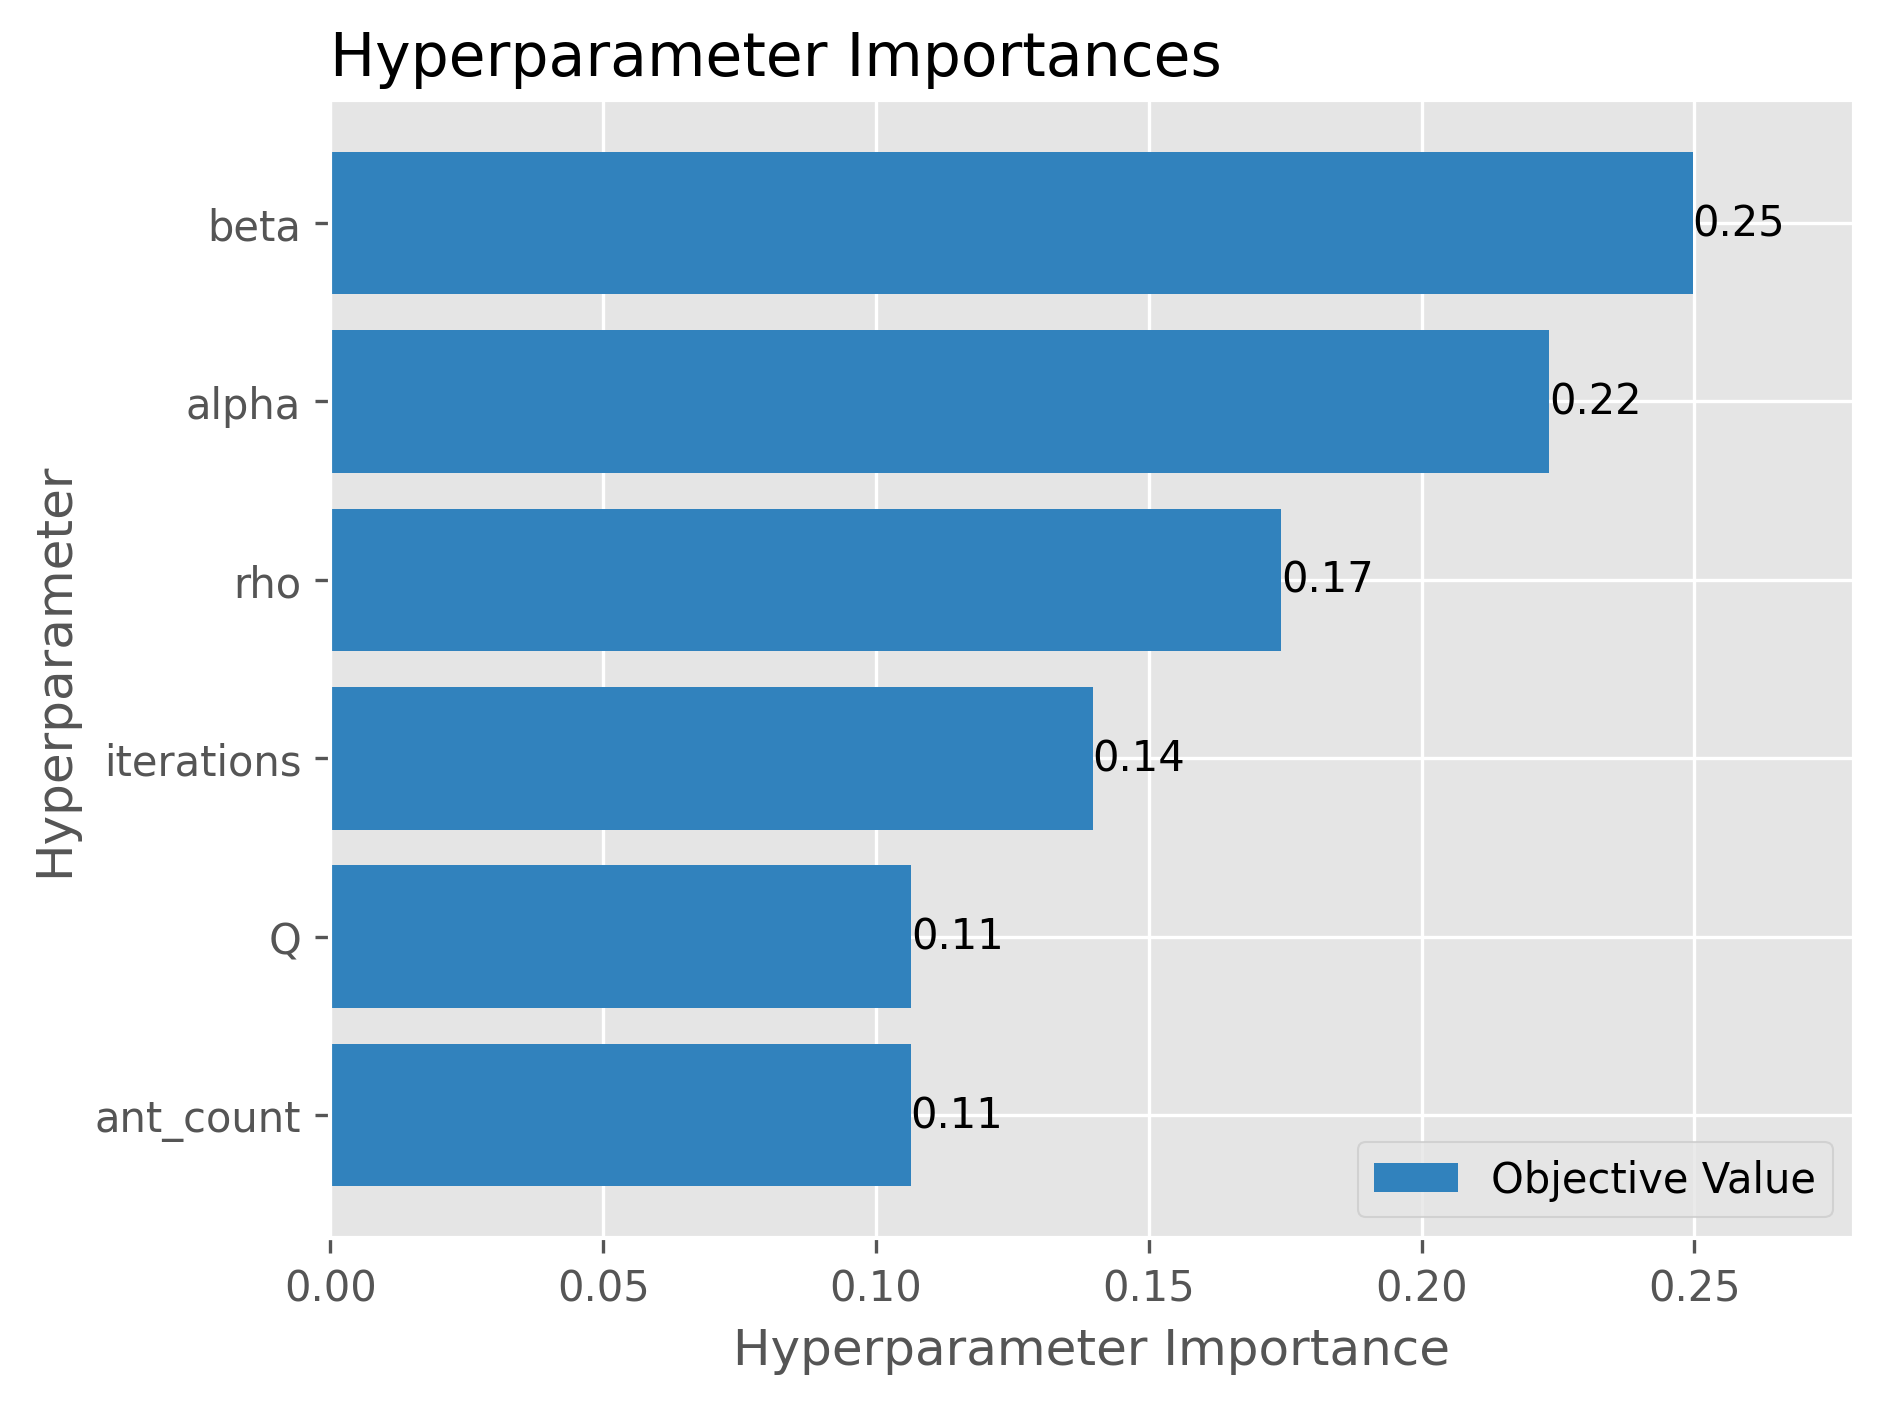

✓ importances.png


### Slice Plots (All Parameters)

*Shows how each parameter affects objective value*

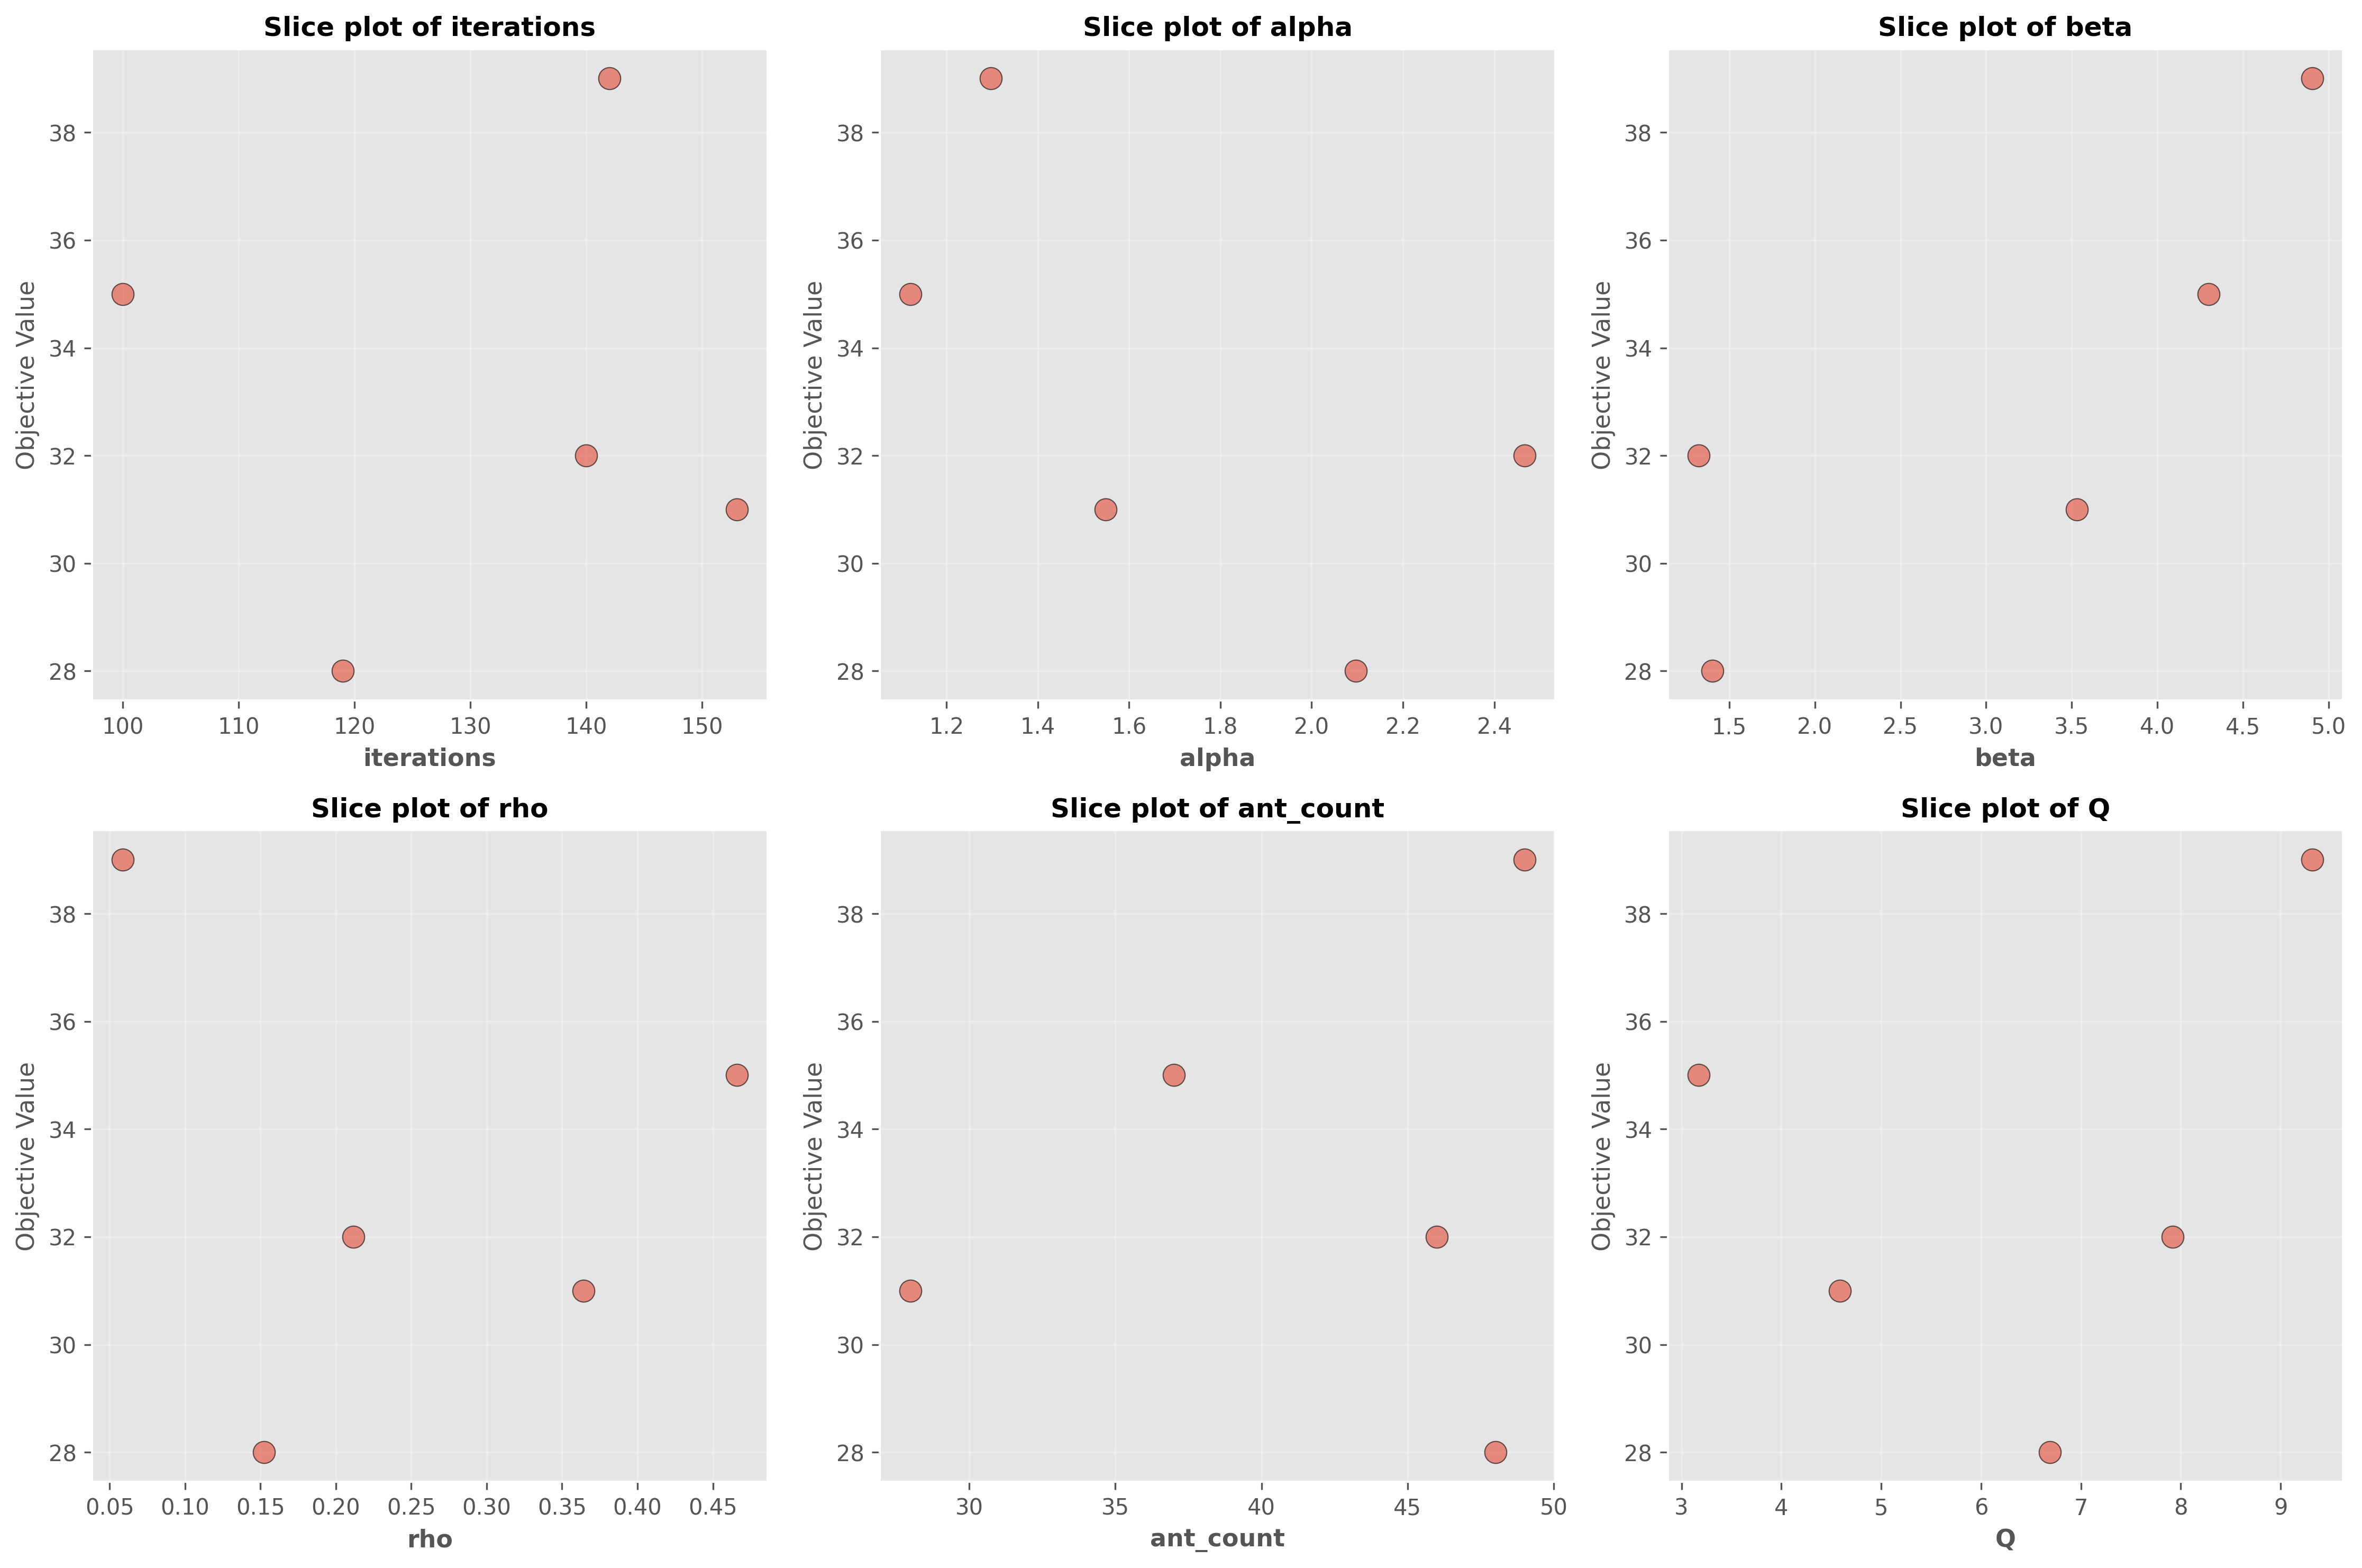

✓ slice.png


### Trial Timeline

*Shows when each trial ran and how long it took*

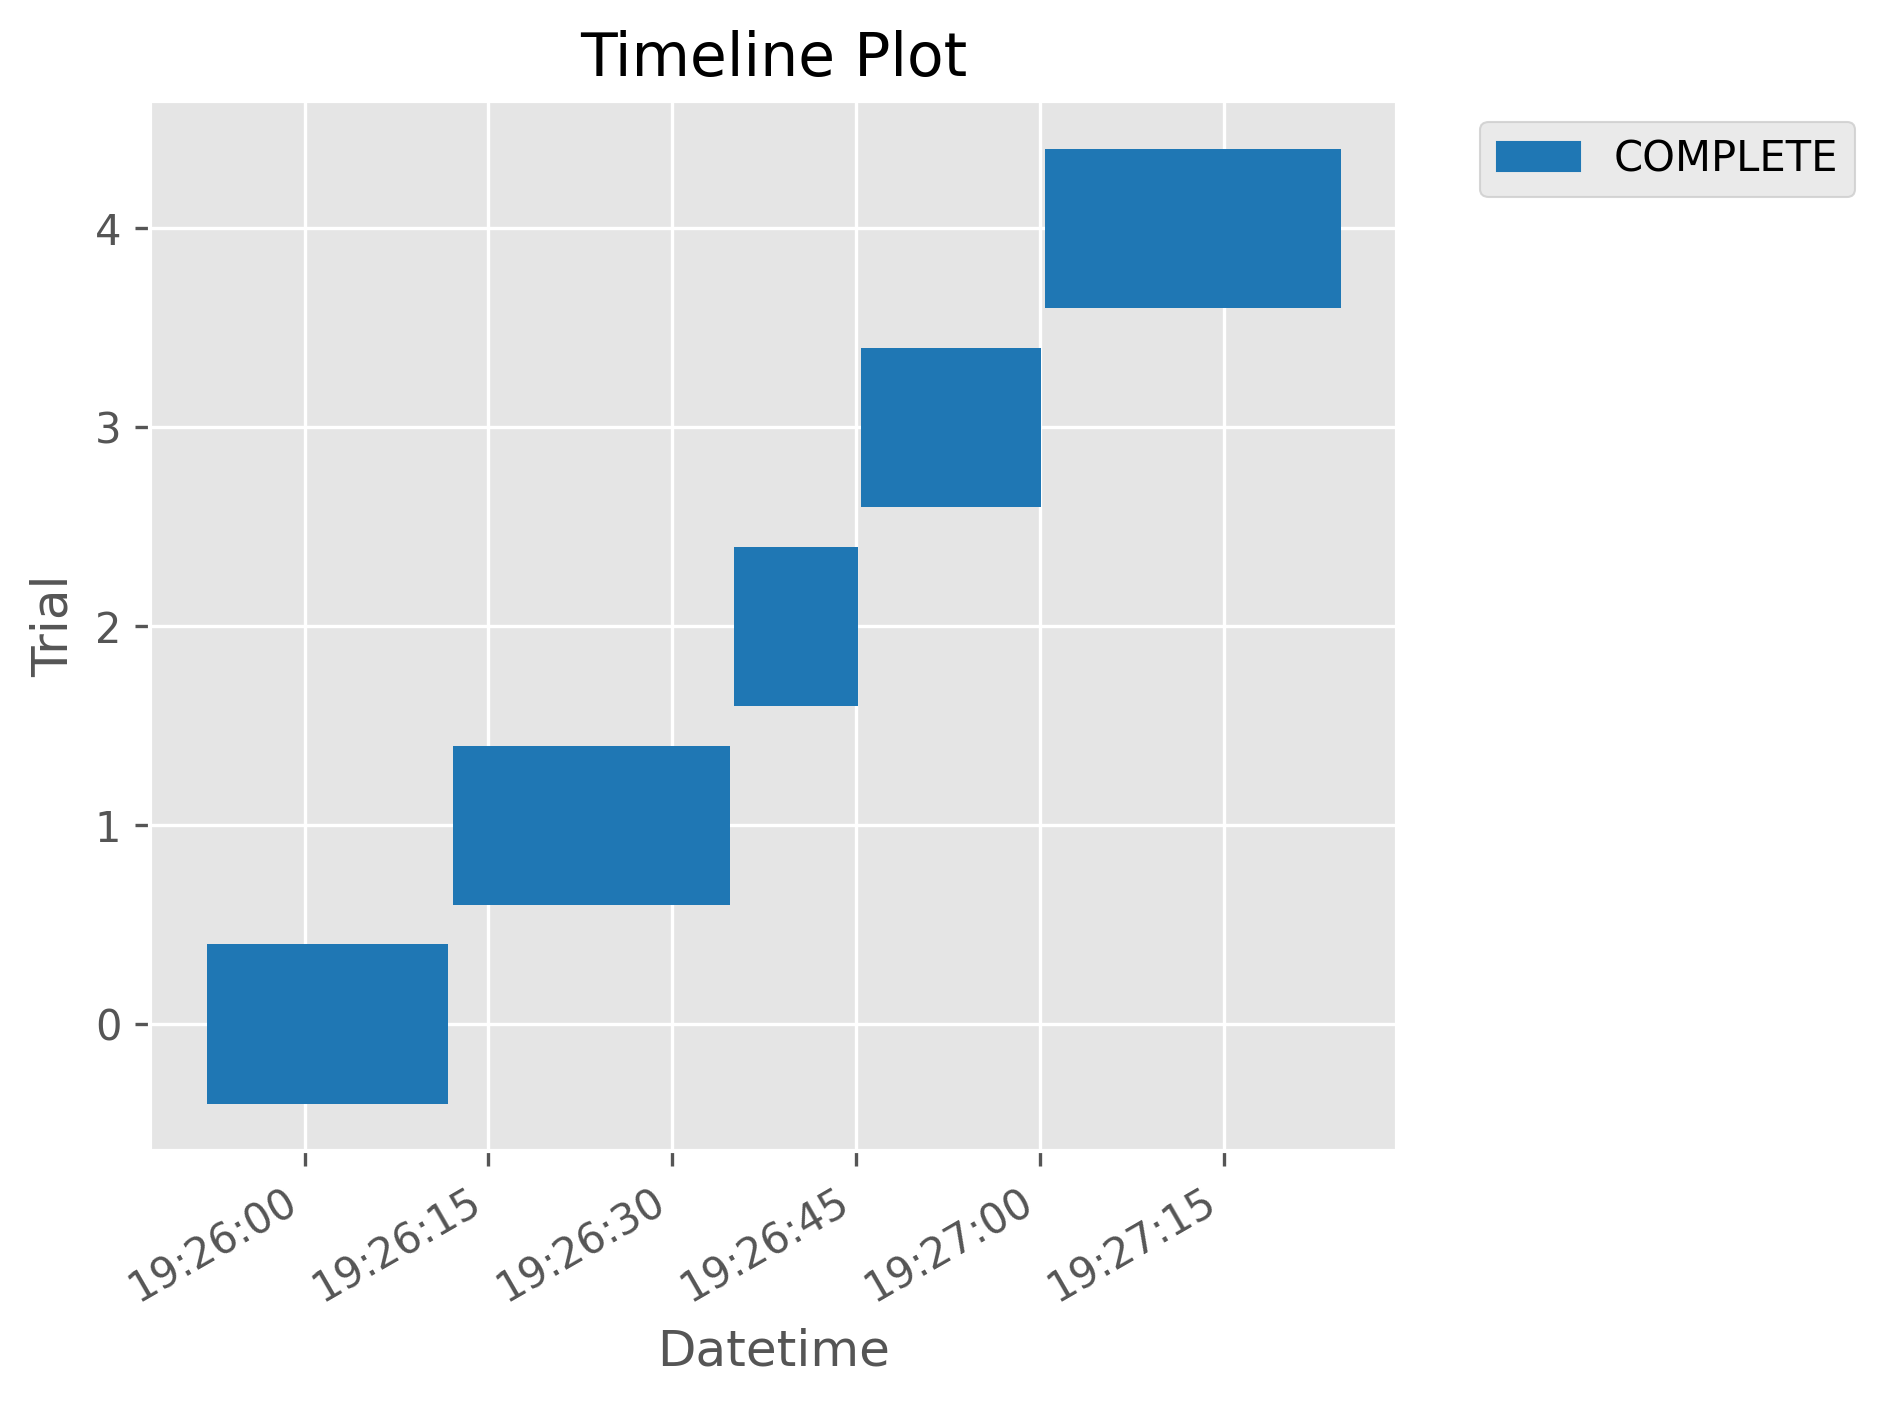

✓ timeline.png


In [10]:
# Display all study figures
from pathlib import Path
from IPython.display import Image, display, Markdown

study_figures_path = Path(DATA_ROOT) / 'studies' / STUDY_NAME / 'figures'

# List of all possible study figures with descriptions
figure_files = [
    ('history.png', 'Optimization History', 'Shows objective value progression across trials'),
    ('importances.png', 'Parameter Importances', 'Shows which hyperparameters impact results most'),
    ('slice.png', 'Slice Plots (All Parameters)', 'Shows how each parameter affects objective value'),
    ('timeline.png', 'Trial Timeline', 'Shows when each trial ran and how long it took')
]

print("Study Visualization Figures:")
print("=" * 70)

for filename, title, description in figure_files:
    figure_path = study_figures_path / filename
    if figure_path.exists():
        display(Markdown(f"### {title}"))
        display(Markdown(f"*{description}*"))
        display(Image(filename=str(figure_path)))
        print(f"✓ {filename}")
    else:
        print(f"✗ {filename} (not generated - may require additional dependencies)")

print("=" * 70)

## 4. Test Best Parameters on Testing Dataset

Evaluate the best parameters on the testing dataset.

In [11]:
# Initialize data loader for testing
test_loader = GraphDataLoader(str(DATA_ROOT), DATASET_NAME)

# Store testing results
testing_results = {}

print("\n" + "=" * 70)
print("TESTING PHASE: Evaluating Best Parameters on Testing Dataset")
print("=" * 70)
print(f"\nBest parameters from optimization:")
for param_name, param_value in best_params.items():
    if isinstance(param_value, float):
        print(f"  {param_name:12s} = {param_value:.4f}")
    else:
        print(f"  {param_name:12s} = {param_value}")
print(f"\n{'-'*70}\n")

# Test on each graph in the testing dataset
for idx, (graph_name, graph) in enumerate(test_loader.load_testing_dataset(), 1):
    print(f"Testing Graph {idx}: {graph_name}")
    print(f"  Graph properties: {len(graph.nodes())} nodes, {len(graph.edges())} edges")
    
    # Create ACO instance with best parameters and slightly more iterations for thorough testing
    test_params = best_params.copy()
    test_params['iterations'] = int(test_params['iterations'] * 1.5)  # 50% more iterations for testing
    test_params['verbose'] = False
    
    print(f"  Running ACO with {test_params['iterations']} iterations...")
    
    aco = ACOGraphColoring(graph=graph, **test_params)
    
    # Run ACO optimization
    import time
    start_time = time.time()
    result = aco.run()
    elapsed_time = time.time() - start_time
    
    # Store results (including graph and solution for visualization)
    testing_results[graph_name] = {
        'color_count': result['color_count'],
        'conflict_count': result['conflict_count'],
        'iterations_used': result['iterations'],
        'best_solution': result['best_solution'],
        'graph': graph,
        'elapsed_time': elapsed_time
    }
    
    print(f"  ✓ Result: {result['color_count']} colors, {result['conflict_count']} conflicts")
    print(f"  ✓ Time: {elapsed_time:.2f}s\n")

print("=" * 70)
print("Testing phase completed!")
print("=" * 70)


TESTING PHASE: Evaluating Best Parameters on Testing Dataset

Best parameters from optimization:
  iterations   = 119
  alpha        = 2.0968
  beta         = 1.4014
  rho          = 0.1523
  ant_count    = 48
  Q            = 6.6888

----------------------------------------------------------------------


Loading Testing Dataset: tiny_dataset
  gc_70_9:
    Nodes: 72, Edges: 2159
    Density: 0.8447, Connected: False

Testing Graph 1: gc_70_9
  Graph properties: 72 nodes, 2159 edges
  Running ACO with 178 iterations...
  ✓ Result: 26 colors, 39 conflicts
  ✓ Time: 51.51s

Testing phase completed!
  ✓ Result: 26 colors, 39 conflicts
  ✓ Time: 51.51s

Testing phase completed!


In [12]:
# Export results and generate visualizations
print("\nExporting testing results and generating visualizations...")
exported_files = export_results(testing_results, best_params, STUDY_NAME, DATA_ROOT)
testing_path = visualize_testing_results(testing_results, STUDY_NAME, DATA_ROOT)

print(f"✓ Testing results saved to study: {STUDY_NAME}")


Exporting testing results and generating visualizations...
✓ Testing results saved to study: aco_study_tiny_dataset_20251129_192552
✓ Testing results saved to study: aco_study_tiny_dataset_20251129_192552


###  Display Testing Results

Show the testing results figure and summary statistics.

### Testing Results Summary

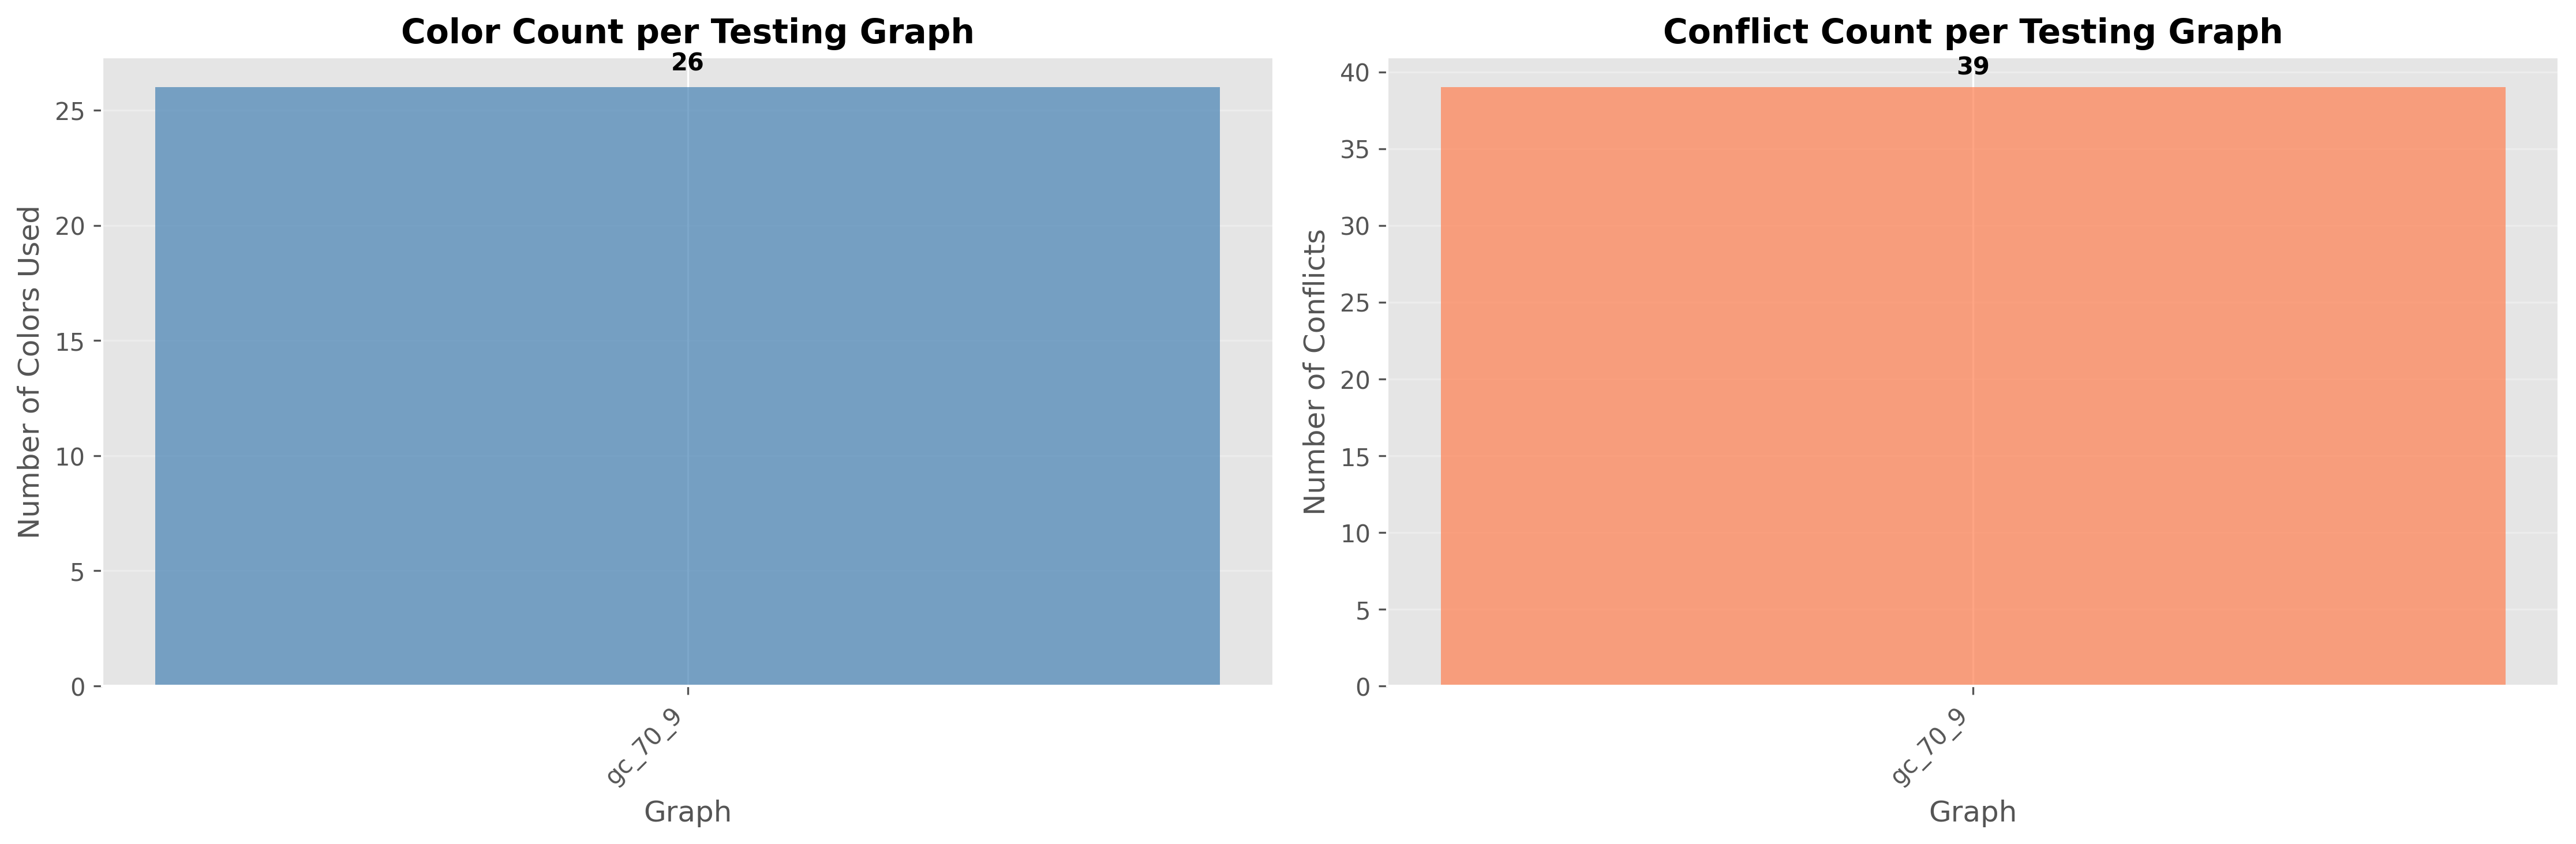

### Testing: Colored Graph Visualizations

#### gc_70_9

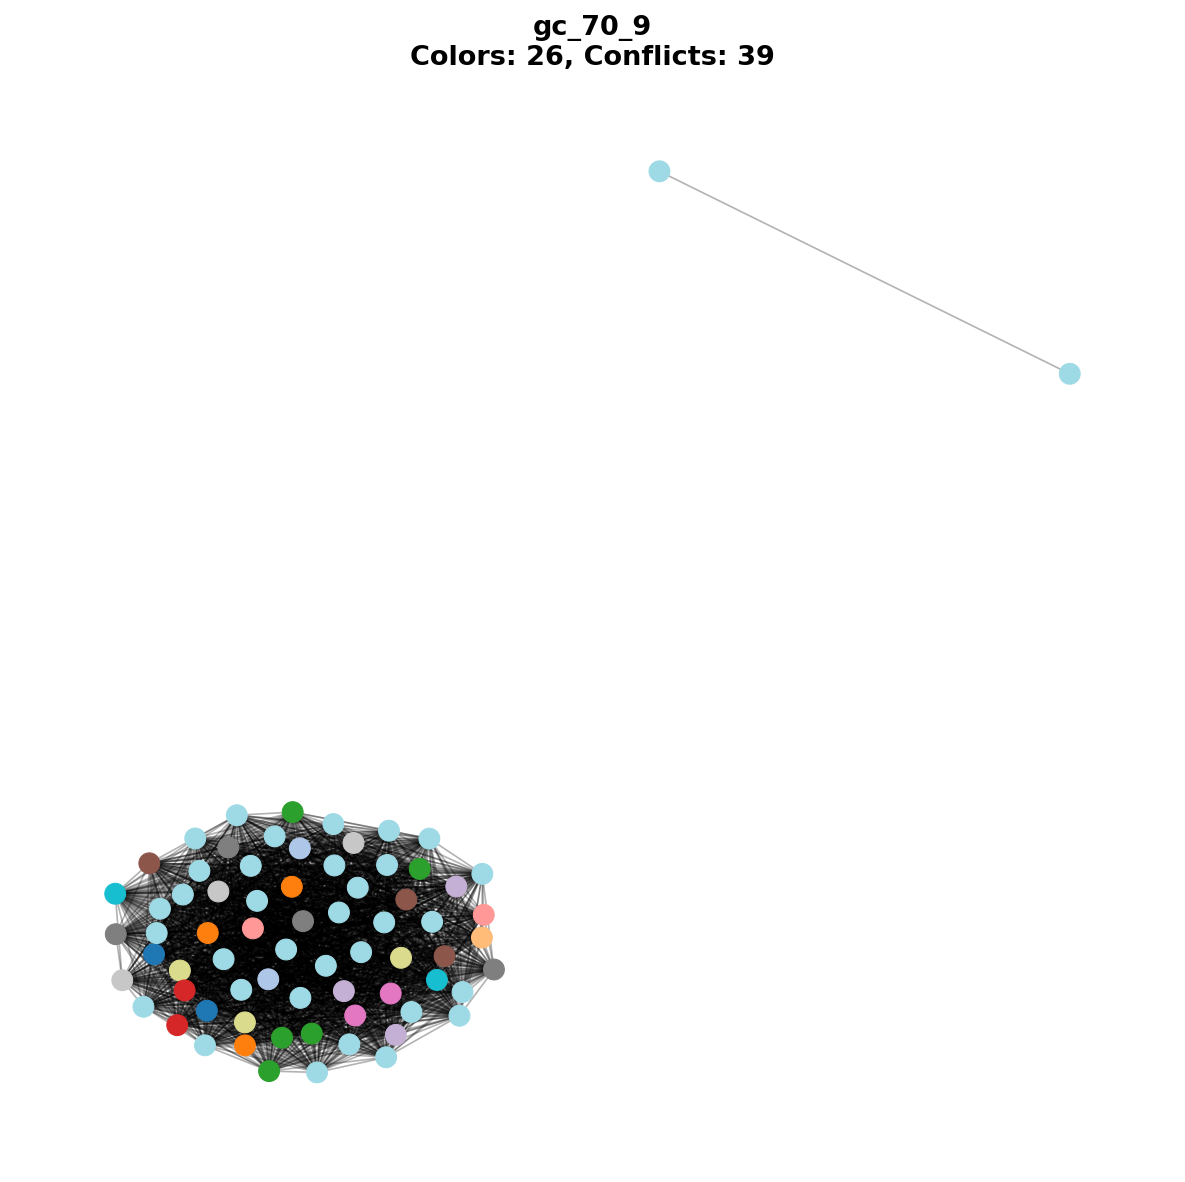




TESTING RESULTS SUMMARY
  Graph  Colors Used  Conflicts  Iterations
gc_70_9           26         39         178

STATISTICS
Average Colors Used: 26.00
Average Conflicts: 39.00
Total Graphs Tested: 1
Graphs with Zero Conflicts: 0


In [13]:
# Display testing results summary figure
display(Markdown("### Testing Results Summary"))
summary_fig_path = testing_path / 'summary.png'
if summary_fig_path.exists():
    display(Image(filename=str(summary_fig_path)))

# Display colored graph visualizations from testing
display(Markdown("### Testing: Colored Graph Visualizations"))
for graph_name in testing_results.keys():
    graph_fig_path = testing_path / f"graph_{graph_name}.png"
    if graph_fig_path.exists():
        display(Markdown(f"#### {graph_name}"))
        display(Image(filename=str(graph_fig_path)))
        
        
# Print summary statistics
print("\n")
print_summary_statistics(exported_files['summary_df'])

In [14]:
# Print file locations
print_file_locations(STUDY_NAME, DATA_ROOT, exported_files, testing_path)


FILE LOCATIONS

Study Folder: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data/studies/aco_study_tiny_dataset_20251129_192552

Study Files:
  Study Log: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data/studies/aco_study_tiny_dataset_20251129_192552/aco_study_tiny_dataset_20251129_192552.log
  Study Summary: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data/studies/aco_study_tiny_dataset_20251129_192552/aco_study_tiny_dataset_20251129_192552_summary.json

Testing Results (testing/):
  Results JSON: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data/studies/aco_study_tiny_dataset_20251129_192552/testing/results.json
  Summary CSV: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data/studies/aco_study_tiny_dataset_20251129_192552/testing/summary.csv
  Best Params CSV: /Users/mahdy/projects/meta_graph_coloring_antcol/assignemnt3/data/studies/aco_study_tiny_dataset_20251129_192552/testing/best_params.csv
  Summar